In [1]:
import pandas as pd
import ast
import networkx as nx
import os
import matplotlib.pyplot as plt
# go one up
os.chdir("..")
plt.style.use("https://raw.githubusercontent.com/allfed/ALLFED-matplotlib-style-sheet/main/ALLFED.mplstyle")

In [2]:
main_color = "#5b3d91"
vos_meta = pd.read_csv(f'data{os.sep}prepared{os.sep}vos_meta.csv')
vos_meta.head()

,VOS_ID,Authors,Title,Year,Citations,Source,Cluster,Links,Total link strength,Norm. citations
0,2,['Nick Bostrom'],Existential Risk Prevention As Global Priority,2013,387.0,Global policy,3,303.0,33.0,11.8575
1,3,['Nick Bostrom'],Existential Risks: Analyzing Human Extinction ...,2002,176.0,[no source],3,61.0,24.0,3.7625
2,4,"['Shahar Avin', ' Bonnie C. Wintle', ' Julius ...",Classifying Global Catastrophic Risks,2018,68.0,Futures,3,226.0,13.0,4.6723
3,7,"['Simon Beard', ' Lauren Holt', ' Asaf Tzachor...",Assessing Climate Change’S Contribution To Glo...,2021,41.0,Futures,3,287.0,56.0,5.3588
4,8,"['Alexey Turchin', ' David Denkenberger']",Classification Of Global Catastrophic Risks Co...,2018,53.0,Ai & society,1,208.0,22.0,3.6416


In [3]:
# Remove the unrelated clusters
num_papers_before = vos_meta.shape[0]
other_topic_clusters = [6, 7, 8, 14, 15, 16, 18, 19, 22, 23]
vos_meta = vos_meta[~vos_meta["Cluster"].isin(other_topic_clusters)]
num_papers_after = vos_meta.shape[0]
print(f"Removed {num_papers_before - num_papers_after} papers from unrelated clusters")

Removed 393 papers from unrelated clusters


In [4]:
years = vos_meta[vos_meta["Year"] < 2024].groupby("Year").size()
# Add 2003, 2005 and 2009 to the years with 0 events
years = years.reindex(range(1970, 2024)).fillna(0)

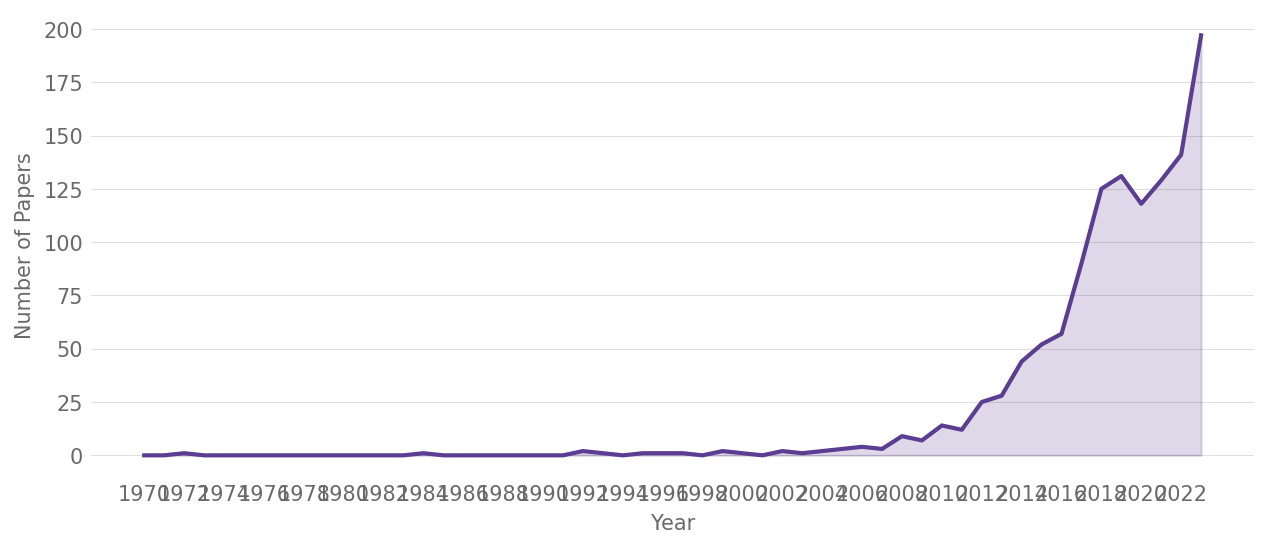

In [5]:
years.plot(kind="line", color=main_color)
# add a fill between the line and the x axis
plt.fill_between(years.index, years, color=main_color, alpha=0.2)
# Remove x grid
plt.gca().xaxis.grid(False)
plt.ylabel("Number of Papers")
# Show every 2nd year
plt.xticks(years.index[::2]);

In [6]:
cluster_years = vos_meta[vos_meta["Year"] < 2024].groupby(["Year", "Cluster"]).size().unstack().fillna(0)

In [7]:
# Only plot the years after 2000 (inclusive)
cluster_years = cluster_years.loc[2000:]

In [8]:
cluster_years.columns = ["AI Ethics", "Climate Change\nGovernance", "Foundations", "Risk Policy", "Pandemics", "Transhumanism", "Reasoning\nand Risk", "Global Resilience\nand Food Security", "Industry, finance,\nand regulation", "International\nRelations", "Bioengineering", "Nuclear Risk", "Quantifying\nClimate Risk"]

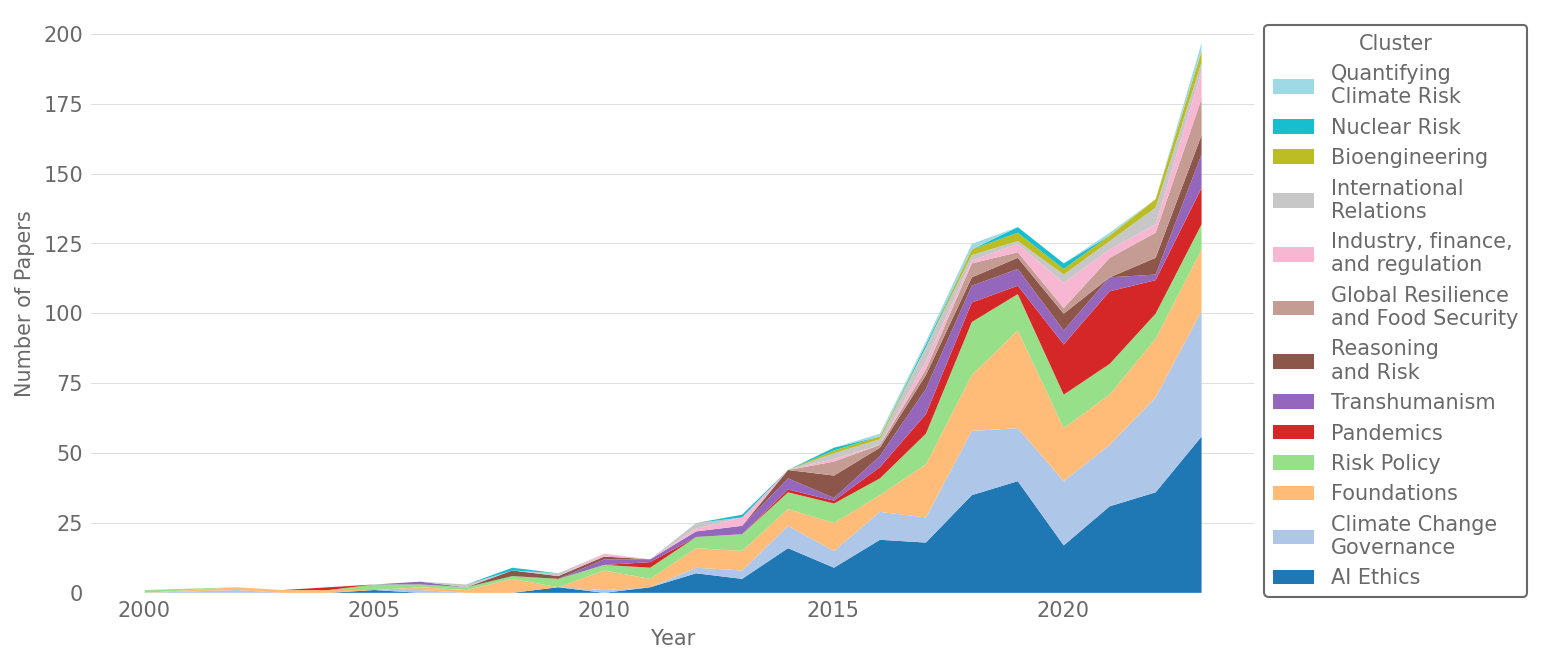

In [22]:
# Plot the area chart
ax = cluster_years.plot(kind="area", colormap="tab20", linewidth=0)

# Get the handles and labels from the current legend
handles, labels = ax.get_legend_handles_labels()

# Reverse the order of both handles and labels
ax.legend(handles[::-1], labels[::-1], title="Cluster", bbox_to_anchor=(1, 1))

# Set y-axis label
plt.ylabel("Number of Papers")

# Remove gridlines from the x-axis
plt.gca().xaxis.grid(False)

fig = plt.gcf()
fig.set_size_inches(10, 5)

# Show the plot
plt.show()


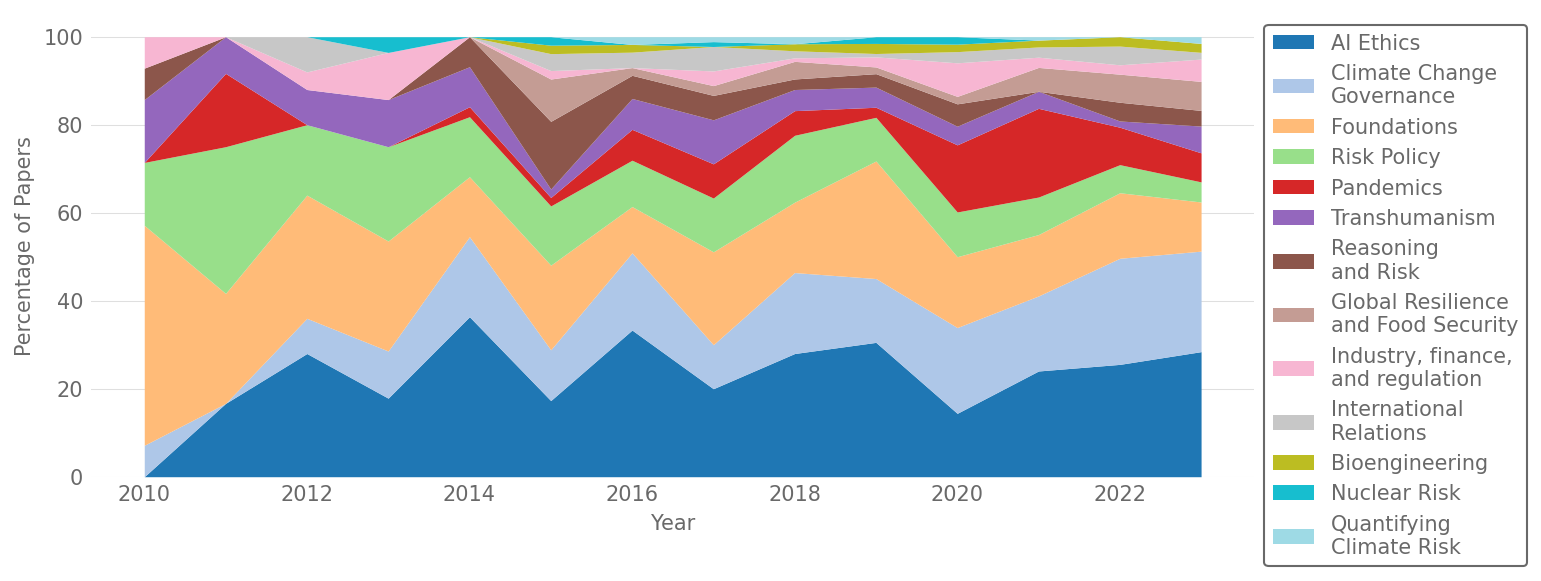

In [10]:
# And now the same plot but with the percentage of papers in each cluster
# Only do this from 2010 onwards
cluster_years_percentage = cluster_years.loc[2010:].div(cluster_years.loc[2010:].sum(axis=1), axis=0) * 100
cluster_years_percentage.plot(kind="area", colormap="tab20", linewidth=0)
plt.gca().legend().set_title("Cluster")
plt.gca().legend().set_bbox_to_anchor((1, 1))
plt.ylabel("Percentage of Papers")
plt.gca().xaxis.grid(False)


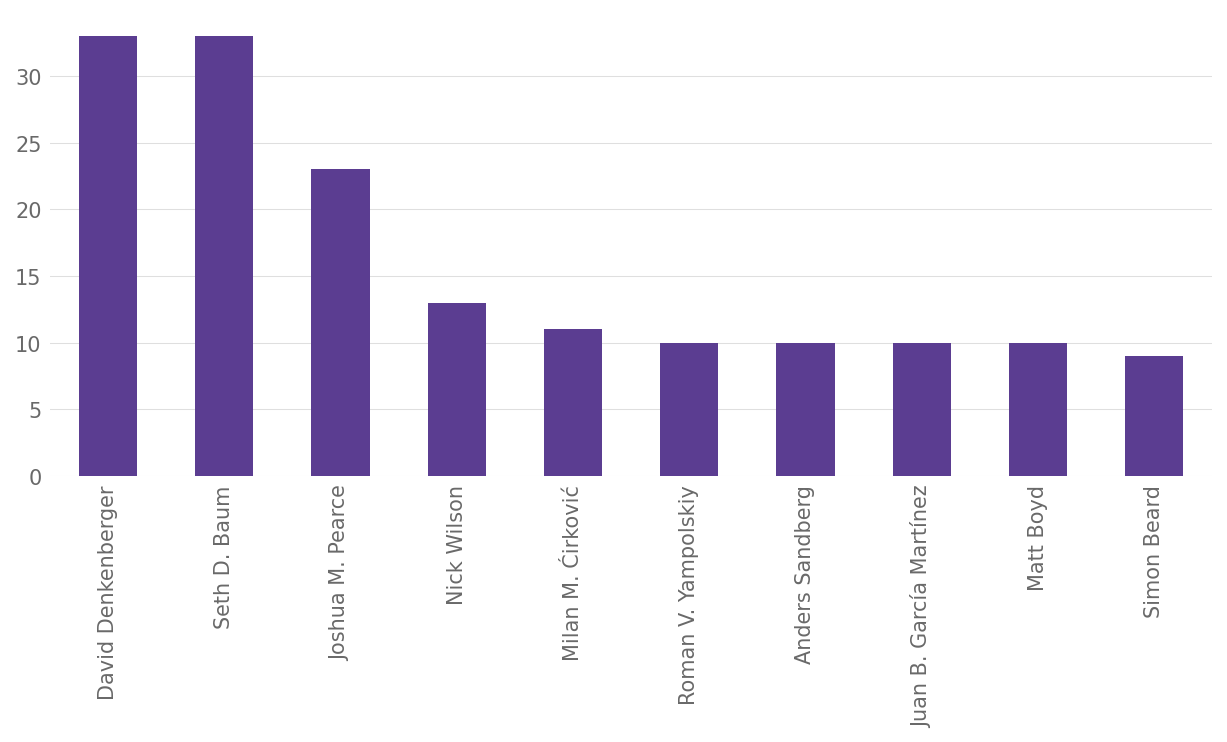

In [19]:
authors = vos_meta["Authors"].apply(ast.literal_eval)
# Create a list of all the authors
all_authors = [author for authors_list in authors for author in authors_list]
# Remove the trailing whitespace from the authors
all_authors = [author.strip() for author in all_authors]
# Count how often each author appears
author_counts = pd.Series(all_authors).value_counts()
author_counts.head(10).plot(kind="bar", color=main_color)
# Remove the x-axis grid
plt.gca().xaxis.grid(False)